<a href="https://colab.research.google.com/github/zeberity123/nvidia-voice-audio-chatbot/blob/main/Hybrid_Demucs_Music_Source_Separation_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Demucs from Colab

This supports the Demucs source separation model (https://github.com/facebookresearch/demucs/)
This is only for separation with pre-trained models, not training!

You can either upload files manually (slow) or link your Google Drive account.

In [ ]:
!python3 -m pip install -U git+https://github.com/facebookresearch/demucs#egg=demucs

  Cloning https://github.com/facebookresearch/demucs to /tmp/pip-install-9qepvpw6/demucs_5d6e375156984879b6916c42616cb736
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/demucs /tmp/pip-install-9qepvpw6/demucs_5d6e375156984879b6916c42616cb736
  Resolved https://github.com/facebookresearch/demucs to commit e976d93ecc3865e5757426930257e200846a520a
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install soundstretch

In [ ]:
from soundstretch import SoundStretch

In [ ]:
!sudo apt-get install ffmpeg
!sudo apt-get install -y python-pydub
!pip install pydub

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-pydub


In [ ]:
from os import path
from pydub import AudioSegment

input_file = "/content/drive/MyDrive/Audio_Project/mixture (1).wav"
output_file = "mixture (1).wav"

sound = AudioSegment.from_mp3(input_file)
sound.export(output_file, format="wav")

<_io.BufferedRandom name='mixture (1).wav'>

In [ ]:
# Customize the following options!
model = "htdemucs"
extensions = ["mp3", "wav", "ogg", "flac"]  # we will look for all those file types.
two_stems = None   # only separate one stems from the rest, for instance
# two_stems = "vocals"

# Options for the output audio.
mp3 = True
mp3_rate = 320
float32 = False  # output as float 32 wavs, unsused if 'mp3' is True.
int24 = False    # output as int24 wavs, unused if 'mp3' is True.
# You cannot set both `float32 = True` and `int24 = True` !!

in_path = '/content/drive/MyDrive/Audio_Project/'
out_path = '/content/drive/MyDrive/Audio_Project/output/'

In [ ]:
#@title Useful functions, don't forget to execute
import io
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO

from google.colab import files

def find_files(in_path):
    out = []
    for file in Path(in_path).iterdir():
        if file.suffix.lower().lstrip(".") in extensions:
            out.append(file)
    return out

def copy_process_streams(process: sp.Popen):
    # this function takes an optional IO[bytes] stream and returns
    # the underlying raw stream, stripping awy anyn buffering or other enhancements
    def raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
        assert stream is not None
        if isinstance(stream, io.BufferedIOBase):
            stream = stream.raw
        return stream

    # creates a dictionary that maps file descriptors to a tuple of stream objects.
    # this allows for capturing and manipulating the output and error streams of a process.
    p_stdout, p_stderr = raw(process.stdout), raw(process.stderr)
    stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
        p_stdout.fileno(): (p_stdout, sys.stdout),
        p_stderr.fileno(): (p_stderr, sys.stderr),
    }
    fds = list(stream_by_fd.keys())

    while fds:
        # `select` syscall will wait until one of the file descriptors has content.
        ready, _, _ = select.select(fds, [], [])
        for fd in ready:
            p_stream, std = stream_by_fd[fd]
            raw_buf = p_stream.read(2 ** 16)
            if not raw_buf:
                fds.remove(fd)
                continue
            # even if the buffer is not full, flushing the StringIO object
            # ensures that all data written to it is available for reading immediately
            buf = raw_buf.decode()
            std.write(buf)
            std.flush()

def separate(inp=None, outp=None):
    inp = inp or in_path
    outp = outp or out_path
    cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    files = [str(f) for f in find_files(inp)]
    if not files:
        print(f"No valid audio files in {in_path}")
        return
    print("Going to separate the files:")
    print('\n'.join(files))
    print("With command: ", " ".join(cmd))
    p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")


def from_upload():
    out_path = Path('separated')
    in_path = Path('tmp_in')

    if in_path.exists():
        rmtree(in_path)
    in_path.mkdir()

    if out_path.exists():
        rmtree(out_path)
    out_path.mkdir()

    uploaded = files.upload()
    for name, content in uploaded.items():
        (in_path / name).write_bytes(content)
    separate(in_path, out_path)


In [ ]:
# This can be quite slow, in particular the loading, and saving from GDrive. Please be patient!
# This is from google drive! Also, this will separate all the files inside the MyDrive/demucs folder,
# so when you are happy with the results, remove the songs from there.
separate()

Going to separate the files:
/content/drive/MyDrive/Audio_Project/03-01-04-01-01-02-06.wav
/content/drive/MyDrive/Audio_Project/fear.wav
/content/drive/MyDrive/Audio_Project/disgust.wav
/content/drive/MyDrive/Audio_Project/happy.wav
/content/drive/MyDrive/Audio_Project/sad.wav
/content/drive/MyDrive/Audio_Project/neutural.wav
/content/drive/MyDrive/Audio_Project/ps.wav
/content/drive/MyDrive/Audio_Project/angry.wav
/content/drive/MyDrive/Audio_Project/mixture (1).wav
With command:  python3 -m demucs.separate -o /content/drive/MyDrive/Audio_Project/output/ -n htdemucs --mp3 --mp3-bitrate=320
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/drive/MyDrive/Audio_Project/output/htdemucs
Separating track /content/drive/MyDrive/Audio_Project/03-01-04-01-01-02-06.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:03<00:00,  1.57seconds/s]


Separating track /content/drive/MyDrive/Audio_Project/fear.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:00<00:00, 22.26seconds/s]


Separating track /content/drive/MyDrive/Audio_Project/disgust.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:00<00:00, 23.61seconds/s]


Separating track /content/drive/MyDrive/Audio_Project/happy.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:00<00:00, 22.46seconds/s]


Separating track /content/drive/MyDrive/Audio_Project/sad.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:00<00:00, 17.05seconds/s]


Separating track /content/drive/MyDrive/Audio_Project/neutural.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:00<00:00, 17.84seconds/s]


Separating track /content/drive/MyDrive/Audio_Project/ps.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:00<00:00, 24.91seconds/s]


Separating track /content/drive/MyDrive/Audio_Project/angry.wav


100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:00<00:00, 25.71seconds/s]


Separating track /content/drive/MyDrive/Audio_Project/mixture (1).wav


100%|██████████████████████████████████████████████████████████████████████| 204.75/204.75 [00:08<00:00, 24.42seconds/s]


In [ ]:
# This is manual upload and download :)
#from_upload()
!zip -r separated.zip separated
files.download('./separated.zip')

updating: separated/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import torchaudio

In [ ]:
print(torch.__version__)
print(torchaudio.__version__)

2.0.1+cu117
2.0.2+cu117


In [ ]:
!pip install mir_eval

In [ ]:
from IPython.display import Audio
from mir_eval import separation
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.utils import download_asset

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
sample_rate = bundle.sample_rate
print(f"Sample rate: {sample_rate}")

Sample rate: 44100


In [ ]:
from torchaudio.transforms import Fade

def separate_sources(
    model,
    mix,
    segment=10.0,
    overlap=0.1,
    device=None,
):
  if device is None:
    device = mix,device
  else:
    device = torch.device(device)

  batch, channels, length = mix.shape

  chunk_len = int(sample_rate * segment * (1 + overlap))
  start = 0
  end = chunk_len

  overlap_frames = overlap * sample_rate
  fade = Fade(fade_in_len = 0, fade_out_len = int(overlap_frames), fade_shape="linear")

  final = torch.zeros(batch, len(model.sources), channels, length, device=device)

  while start < length - overlap_frames:
    chunk = mix[:, :, start:end]
    with torch.no_grad():
      out = model.forward(chunk)
    out = fade(out)
    final[:, :, :, start:end] += out
    if start == 0:
      fade.fade_in_len = int(overlap_frames)
      start += int(chunk_len - overlap_frames)
    else:
      start += chunk_len
    end += chunk_len
    if end >= length:
      fade.fade_out_len = 0
  return final

In [ ]:
def plot_spectrogram(stft, title="Spectrogram"):
  magnitude = stft.abs()
  spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
  _, axis = plt.subplots(1,1)
  axis.imshow(spectrogram, cmap="viridis", vmin=-60, vmax=0, origin="lower", aspect="auto")
  plt.tight_layout()

In [ ]:
SAMPLE_SONG = download_asset("/content/mixture (1).wav")
waveform, sample_rate = torchaudio.load(SAMPLE_SONG)
waveform = waveform.to(device)
mixture = waveform

segment: int = 10
overlap = 0.1

print("Separating Track")

ref = waveform.mean(0)
waveform = (waveform - ref.mean()) / ref.std()

sources = separate_sources(
    model,
    waveform[None],
    device = device,
    segment = segment,
    overlap=overlap,
)[0]

sources = sources * ref.std() + ref.mean()

sources_list = model.sources
sources = list(sources)

audios = dict(zip(sources_list, sources))

Separating Track


In [ ]:
N_FFT = 4096
N_HOP = 4
stft = torchaudio.transforms.Spectrogram(
    n_fft = N_FFT,
    hop_length = N_HOP,
    power = None,
)

In [ ]:
def output_results(original_source: torch.Tensor, predicted_source: torch.Tensor, source: str):
  print(
      "Source-to-Distortion Ratio (SDR) score is",
      separation.bss_eval_sources(original_source.detach().numpy(),
                                  predicted_source.detach().numpy())[0].mean(),
  )
  plot_spectrogram(stft(predicted_source)[0], f"Spectrogram - {source}")
  return Audio(predicted_source, rate=sample_rate)

In [ ]:
segment_start = 150
segment_end = 155

frame_start = segment_start * sample_rate
frame_end = segment_end * sample_rate


vocals_original = download_asset("tutorial-assets/hdemucs_vocals_segment.wav")
other_original = download_asset("tutorial-assets/hdemucs_other_segment.wav")



vocals_spec = audios["vocals"][:, frame_start:frame_end].cpu()
vocals, sample_rate = torchaudio.load(vocals_original)

other_spec = audios["other"][:, frame_start:frame_end].cpu()
other, sample_rate = torchaudio.load(other_original)

mix_spec = mixture[:, frame_start:frame_end].cpu()

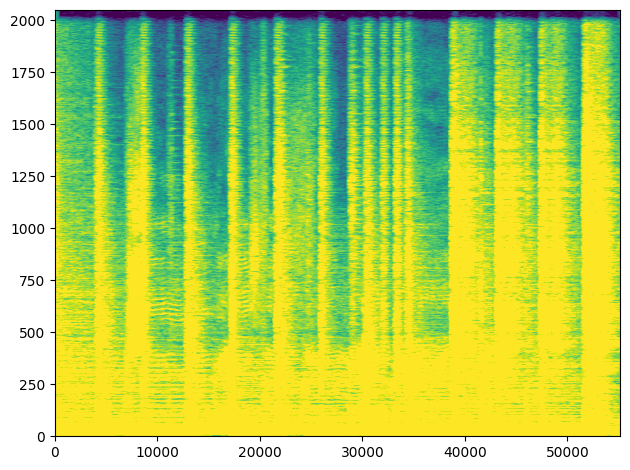

In [ ]:
plot_spectrogram(stft(mix_spec)[0], "Spectrogram - Mixture")
Audio(mix_spec, rate=sample_rate)

Source-to-Distortion Ratio (SDR) score is -20.42381766340962


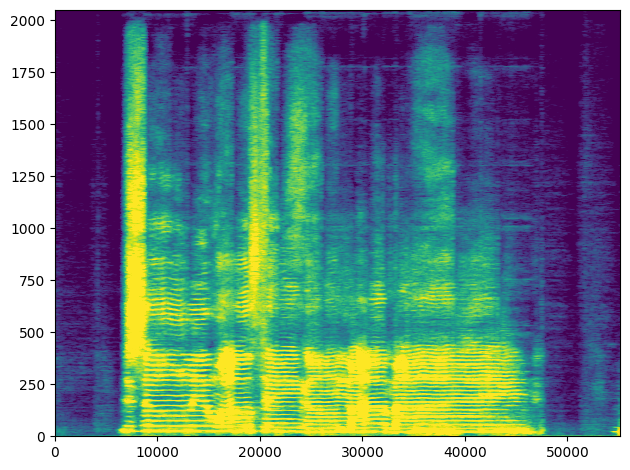

In [ ]:
output_results(vocals, vocals_spec, "vocals")